# Importing Module and define directories

In [1]:
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
importlib.reload(MLP)
from MLP import MLP

# Train - Validation Split

In [2]:
data=np.loadtxt("../../data/TR.csv",delimiter=",")
input_data=data[:,1:-2][0:1000]
labels=data[:,-2:][0:1000]
val_data=data[:,1:-2][1000:-1]
val_labels=data[:,-2:][1000:-1]

# Define the MLP

In [10]:
structure=[10,8,20,np.shape(labels)[1]]
act_func=[("sigmoid",1),("sigmoid",1),("sigmoid",1),("linear",1)]
start=[0.001,0.05,0.05,0.01]
learning_rate=5e-6
lamb=1e-5
netw = MLP(structure, func=act_func,
           starting_points=start, 
           eta = learning_rate, lamb = lamb)

## Train the model

In [11]:
N_epoch = 100
netw.train(input_data, labels, val_data, val_labels, epoch = N_epoch,batch_size=1)

Epoch 100:  [train MEE = 7.3234]  [val MEE = 7.0293]                              
Elapsed time: 17.838836908340454 s


## Predict the output

In [6]:
train_pred = netw.predict(input_data)
val_pred = netw.predict(val_data)

# Plot results

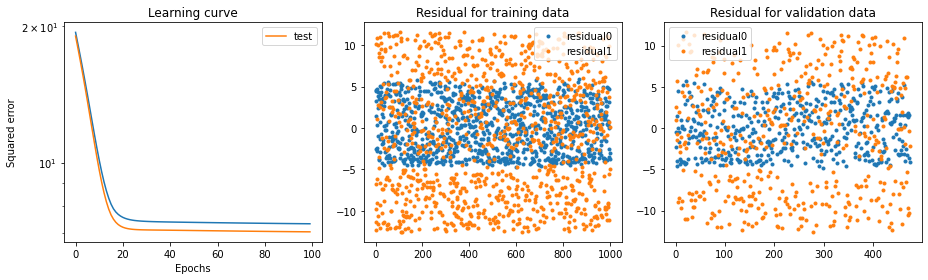

In [12]:
def plot_results(network):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_results(netw)

In [13]:
from MLP import shuffle

In [17]:
a=np.reshape(np.arange(0,22),(11,2))

In [18]:
b=np.reshape(np.arange(0,11),(11,1))

In [19]:
a

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19],
       [20, 21]])

In [20]:
b

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [24]:
shuffle(a,b)

In [25]:
a

array([[ 4,  5],
       [ 0,  1],
       [20, 21],
       [16, 17],
       [ 8,  9],
       [18, 19],
       [10, 11],
       [12, 13],
       [ 2,  3],
       [14, 15],
       [ 6,  7]])

In [26]:
b

array([[ 2],
       [ 0],
       [10],
       [ 8],
       [ 4],
       [ 9],
       [ 5],
       [ 6],
       [ 1],
       [ 7],
       [ 3]])